In [2]:
from PIL import Image
import numpy as np
import cv2

In [1]:
from PIL import Image

file_path = "Downloads/Kayıpsız sıkıştırma orijinal örneği.tif"

# Dosyayı aç
with Image.open(file_path) as img:
    print("Gerçek dosya formatı:", img.format)

Gerçek dosya formatı: TIFF


In [5]:
# 1. TIFF görüntüsünü oku
image = Image.open("Downloads/Kayıpsız sıkıştırma orijinal örneği.tif").convert("L")  # Gri tonlamalı TIFF
pixel_data = np.array(image).tobytes()  # Görüntüdeki pikseller byte dizisine çevrilir


In [3]:
def lzw_compress(uncompressed):
    """LZW algoritması ile sıkıştırma"""
    dictionary = {bytes([i]): i for i in range(256)}
    dict_size = 256  #0-255 arası tüm tek karakterli bytelar (başlangıçtaki piksel değerleri) sözlüğe eklenir
    result = []
    w = b"" 

    for c in uncompressed:
        wc = w + bytes([c])
        if wc in dictionary:   #byte dizisi okunur ve eğer[120,120,120] gibi tekrar eden değerler piksel değerleri olduğunda yeni bir desen oluşturulur ve buna bir kod atanır  
            w = wc             #böylelikle tekrar eden piksel değerleri  örüntü oluşturularak kayıpsız sıkıştırma yapmış oluruz.
        else:
            result.append(dictionary[w])
            dictionary[wc] = dict_size
            dict_size += 1
            w = bytes([c])

    if w:
        result.append(dictionary[w])

    return     

In [4]:
def lzw_decompress(compressed):
    """sıkıştırlmış kod listesini tekrar orijinal byte dizisine dönüştürmek"""
    dictionary = {i: bytes([i]) for i in range(256)}
    dict_size = 256
    result = bytearray()
    
    w = bytes([compressed.pop(0)])
    result.extend(w)
    
    for k in compressed:
        if k in dictionary:
            entry = dictionary[k]
        elif k == dict_size:
            entry = w + w[:1]
        else:
            raise ValueError("Hatalı sıkıştırılmış veri")

        result.extend(entry)
        dictionary[dict_size] = w + entry[:1]
        dict_size += 1
        w = entry

    return result

In [6]:
# 2. LZW ile sıkıştır
compressed_data = lzw_compress(pixel_data)
print("Sıkıştırılmış veri boyutu:", len(compressed_data))


Sıkıştırılmış veri boyutu: 5456338


In [7]:
# 3. LZW ile geri açıyoruz orjinal byte dizilerini
decompressed_data = lzw_decompress(compressed_data)


In [8]:
# 4. Açılan veriyi tekrar görüntüye dönüştür
decompressed_image = Image.frombytes("L", image.size, bytes(decompressed_data))


In [9]:
# 5. Görüntüleri yan yana göster
import matplotlib.pyplot as plt

(np.float64(-0.5), np.float64(5999.5), np.float64(3999.5), np.float64(-0.5))

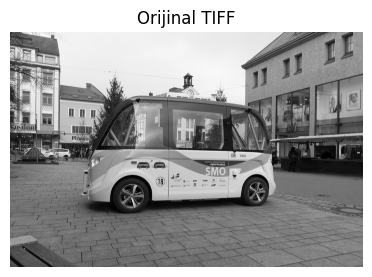

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Orijinal TIFF")
plt.imshow(image, cmap="gray")
plt.axis("off")

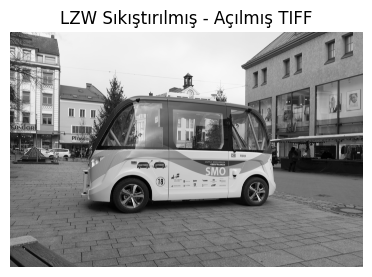

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.title("LZW Sıkıştırılmış - Açılmış TIFF")
plt.imshow(decompressed_image, cmap="gray")
plt.axis("off")

plt.show()

In [12]:
from PIL import Image
import numpy as np

# Eğer decompressed_image NumPy dizisi değilse, NumPy formatına çevir
if not isinstance(decompressed_image, np.ndarray):
    decompressed_image = np.array(decompressed_image, dtype=np.uint8)

# NumPy dizisini TIFF olarak kaydetmek için PIL Image formatına çevir
image_to_save = Image.fromarray(decompressed_image)

cv2.imwrite("compressed_output06.tiff", decompressed_image)

print("✅ LZW sıkıştırılmış TIFF dosyası kaydedildi!")


✅ LZW sıkıştırılmış TIFF dosyası kaydedildi!


In [13]:
from PIL import Image

# TIFF dosyasını aç
tiff_path = "compressed_output06.tiff"  # Dosya yolunu belirt
img = Image.open(tiff_path)

# Sıkıştırma yöntemini kontrol et
compression_type = img.info.get("compression", "Uncompressed")  
print(f"TIFF Sıkıştırma Türü: {compression_type}")


TIFF Sıkıştırma Türü: tiff_lzw


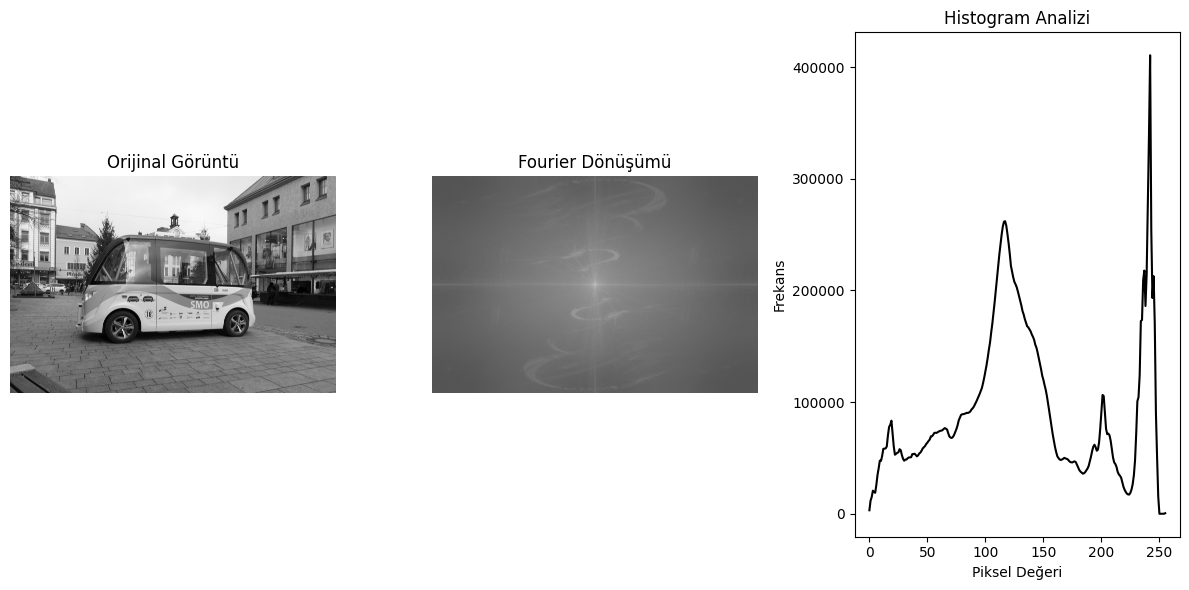

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Görüntüyü yükle
image_path = "compressed_output06.tiff"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Fourier Dönüşümü
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)  

# Histogram Analizi
histogram = cv2.calcHist([image], [0], None, [256], [0,256])

# Görüntü ve analizleri görselleştirme
plt.figure(figsize=(12, 6))

# Orijinal Görüntü
plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Orijinal Görüntü")
plt.axis("off")

# Fourier Dönüşümü
plt.subplot(1, 3, 2)
plt.imshow(magnitude_spectrum, cmap="gray")
plt.title("Fourier Dönüşümü")
plt.axis("off")

# Histogram
plt.subplot(1, 3, 3)
plt.plot(histogram, color='black')
plt.title("Histogram Analizi")
plt.xlabel("Piksel Değeri")
plt.ylabel("Frekans")

plt.tight_layout()
plt.show()

In [16]:
import os

orijinal = os.path.getsize("Downloads/Kayıpsız sıkıştırma orijinal örneği.tif")  # byte
compressed = os.path.getsize("compressed_output06.tiff")  # byte

oran = orijinal / compressed
yuzde = 100 * (1 - compressed / orijinal)

print(f"Sıkıştırma oranı: {oran:.2f}x")
print(f"Sıkıştırma yüzdesi: %{yuzde:.2f}")

Sıkıştırma oranı: 9.89x
Sıkıştırma yüzdesi: %89.89


In [17]:
from PIL import Image

img = Image.open("compressed_output06.tiff")
print(img.info.get("compression"))

tiff_lzw
